# Non-parametric classification via expand-and-sparsify representation: A distributed implementation in Julia

## Introduction
Given a labeled dataset $\{(x_i, y_i)\}_{i=1}^n \subset \mathbb{R}^d \times \{0,1\}$ and a test point $x \in \mathbb{R}^d$, the basic idea of **non-parametric classification** is to construct a function $f_n(x) = f_n(x,x_1,\dots,x_n)$ that approximates the true function $f$ as $n \to \infty$. For any $x \in \mathbb{R}^d$, $f_n(x)$ tipically depends on a small subset of the training set lying within a small neighborhood of $x$. For example, in case of $k$-nearest neighbor, $f_n(x)$ depends on the $k$ points from the dataset that are closest to $x$.

In the paper [Non-parametric classification via expand-and-sparsify representation](https://openreview.net/forum?id=0d50Il6enG), the authors propose a non-parametric classification method where, for any $x$, the appropriate neighborhoods are obtained using an **expand-and-sparsify** (`EaS`) representation of $x$.

### Expand-and-sparsify representation
On a high level, **EaS** representation is a transformation from a lowlevel dimensional dense representation of sensory inputs to a much higher-dimensional, sparse representation. Such representation has been found, for instance, in the olfactory system of the fly.

Formally, the EaS representation is a mapping from a $d$-dimensional unit sphere $S^{d-1}$ to $\{0,1\}^m$, $m \gg d$, where a data point $x \in S^{d-1}$ is randomly mapped to higher dimension $\mathbb{R}^m$ using a random projection matrix $\Theta$, and is followed by a sparsification step, where the most informative $k$ of the $m$ coordinates of $\Theta x \in \mathbb{R}^m$ are set to one and the rest of the coordinates are set to zero. Rows of $\Theta$ are typically drawn independently from some distribution $\pi$ over $S^{d-1}$ or $\mathbb{R}^d$.

### Classification via EaS representation
Let $C_j, j = 1, \dots, m$ be the set of all examples from the input space $S^{d-1}$ whose $j$-th coordinate in respective EaS representation are set to one. We call $C_j$ the *response region* of $\theta_j$ ($j$-th row of $\Theta$).
For any $x \in S^{d-1}$, there are $k$ *activated* response regions corresponding to the $k$ non-zero entries in the EaS representation of $x$. These response regions serves as $k$ neighborhoods of $x$ for the proposed classifier.
For any $x \in S^{d-1}$ and each activated response region $C_j$, we estimate $\text{Pr}(y=1|C_j)$ and take their average to be the estimate of $\text{Pr}(y=1|x)$.

## The algorithm: EaS classifier
The authors propose the following algorithm.

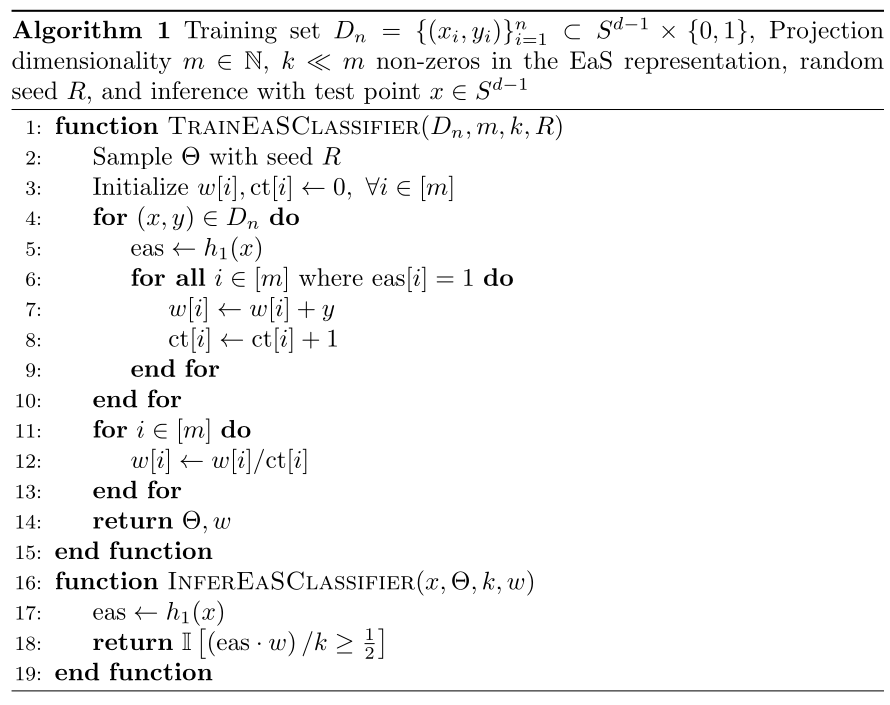

We consider a binary classification setting, where the input space is $\mathcal{X} \subset S^{d-1}$ and the output space is $\mathcal{Y} = \{0, 1\}$.
Let $\mu$ be a measure on $\mathcal{X}$, and let the conditional probability function $\eta: \mathcal{X} \to [0, 1]$ be defined as $\eta(x) = \Pr(y = 1 \mid x)$.
This completely determines the joint distribution over $\mathcal{X} \times \mathcal{Y}$ via $\mu$ and $\eta$. \
Let the training dataset be $\{(x_i, y_i)\}_{i=1}^n$, sampled i.i.d. from $\mu \times \eta$.

For any $x \in S^{d-1}$, its EaS representation using a $k$-Winner-Take-All (k-WTA) step is defined as:

$$
h_1(x) = \Gamma_k(\Theta x),
$$

where:

- $\Theta \in \mathbb{R}^{m \times d}$ is a random projection matrix, with rows $\theta_1, \ldots, \theta_m$ sampled i.i.d. from the uniform distribution on $S^{d-1}$,
- $\Gamma_k: \mathbb{R}^m \to \{0, 1\}^m$ is the k-WTA function that sets the top $k \ll m$ largest entries of $\Theta x$ to 1 and the rest to 0.

For each $j \in [m]$, define the response region:

$$
C_j = \{x \in \mathcal{X} : h_1(x)[j] = 1\}.
$$

Note that the regions $C_1, \ldots, C_m$ may overlap and do not form a partition of $\mathcal{X}$.


During training, we compute a vector $w \in [0, 1]^m$, where each entry $w[j]$ is the average label value in region $C_j$, estimated as:

$$
w[j] = \frac{\sum_{i=1}^n y_i \cdot \mathbb{I}[x_i \in C_j]}{\sum_{i=1}^n \mathbb{I}[x_i \in C_j]} =: \hat{\eta}_j
$$

For any test point $x \in \mathcal{X}$, define the estimated conditional probability as:

$$
\hat{\eta}(x) = \frac{1}{k} \sum_{j: x \in C_j} \hat{\eta}_j
$$

That is, $\hat{\eta}(x)$ is the average of $w[j]$ values corresponding to the $k$ active coordinates in $h_1(x)$. This serves as an estimate for the true conditional probability $\eta(x)$.

The prediction rule is:
$$
\hat{y}(x) = 
\begin{cases}
1 & \text{if } \hat{\eta}(x) \geq \frac{1}{2}, \\
0 & \text{otherwise}
\end{cases}
$$

We can equivalently write:

$$
\hat{\eta}(x) = \frac{w \cdot h_1(x)}{k} = \frac{1}{k} \sum_{j: x \in C_j} \hat{\eta}_j = \frac{1}{k} \sum_{j: x \in C_j} \frac{\sum_{i=1}^n y_i \cdot \mathbb{I}[x_i \in C_j]}{\sum_{i=1}^n \mathbb{I}[x_i \in C_j]}
$$

This can be further re-expressed as:

$$
\hat{\eta}(x) = \sum_{i=1}^n w_{n,i}(x) \cdot y_i,
$$

where the weight $w_{n,i}(x)$ is given by:

$$
w_{n,i}(x) = \frac{1}{k} \sum_{j: x \in C_j} \frac{\mathbb{I}[x_i \in C_j]}{\sum_{i=1}^n \mathbb{I}[x_{i} \in C_j]}.
$$

Thus, the prediction for $x$ is a weighted average of training labels $y_i$, where the weights depend on the overlap of response regions between $x$ and $x_i$.

## EaS classifier implementation in Julia
In the following, we present an implementation of the algorithm proposed by the authors using the Julia programming language. The implementation is distributed and uses the `Distributed` and `DistributedArrays` libraries.
In particular, the training phase is distributed across multiple worker processes, where each worker is responsible for computing the weights $w$ with respect to a partition of the training set.

Let $p$ be the number of workers. The training set $(X, y)$ is partitioned into $p$ subsets $(X_1, y_1), \dots, (X_p, y_p)$ such that:

- $(X_j, y_j) \cap (X_k, y_k) = \emptyset,\ \forall k \neq j$;
- $\bigcup_{j=1}^p (X_j, y_j) = (X, y)$.

Each worker then outputs a weight vector $\{w_j\}_{j=1}^p$, which are combined by the main process using an appropriate reduce operation to obtain the final weight vector $w$, which can be used to make predictions on new data points.

### EaS Classifier: Training
We present the code for the training phase in the following.

In [ ]:
using Pkg
Pkg.add("LinearAlgebra")
Pkg.add("StatsBase")
Pkg.add("BenchmarkTools")
Pkg.add("Distributed")
Pkg.add("DistributedArrays")
Pkg.add("Plots")
Pkg.add("Random")
Pkg.add("MKL")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("MLUtils")
Pkg.add("MLDatasets")

In [1]:
using Random, LinearAlgebra, .Threads, StatsBase
using BenchmarkTools
using Distributed, DistributedArrays

# The LinearAlgebra library is multithreaded;
# to properly test performance improvements when using multiple processes,
# the LinearAlgebra library should use fewer threads (ideally a single thread)

BLAS.set_num_threads(1)

addprocs(2)

@everywhere begin
    using Random, LinearAlgebra, DistributedArrays
end

@everywhere BLAS.set_num_threads(1)
@everywhere using MKL
@everywhere MKL.set_num_threads(1)


The following function generate a $m \times d$ random projection matrix by sampling from the uniform distribution on $S^{d-1}$; $m \in \mathbb{N}$ is the *projection dimensionality*.

In [ ]:
function rupm(m::Int, d::Int; seed::Int=42)
    rng = MersenneTwister(seed)
    mat = randn(rng, m, d)

    # Normalize each row in-place to have unit L2 norm.
    @inbounds for i in 1:m
        # Get a view of the current row to avoid copying data.
        row_view = @view mat[i, :]

        # Calculate the norm of the row.
        row_norm = norm(row_view)

        # Normalize the row. Add a small epsilon for numerical stability.
        # This prevents division by zero if a row happens to be all zeros.
        mat[i, :] ./= (row_norm + eps(eltype(mat)))
    end

    return mat
end

random_projection_matrix (generic function with 1 method)

This is the function executed by each worker $j$ to compute the weights $w_j$ corresponding to its portion of the training set $(X_j, y_j)$. It implements the algorithm proposed by the authors. The use of the `@everywhere` keyword ensures that the function definition is available on all worker processes.

In [ ]:
@everywhere function train_eas_classifier(X, y, P, k)
    d, n = size(X)
    m = size(P, 1)
    w = zeros(eltype(y), m)
    ct = zeros(Int64, m)

    x_proj = Vector{Float64}(undef, m)
    top_k_idx = Vector{Int}(undef, m)

    for i in 1:n
        x_view = X[:, i]
        mul!(x_proj, P, x_view)
        partialsortperm!(top_k_idx, x_proj, k; rev=true)

        label = y[i]
        for j in @view top_k_idx[1:k]
            w[j] += label
            ct[j] += 1
        end
    end

    return w, ct
end

When $k \ll m$, computing the indices of the $k$ largest values in $\Theta x$ can be done much more efficiently with the following strategy. We maintain a buffer containing the current top-$k$ elements. Whenever a new element exceeds the smallest value in the buffer, it replaces that minimum, after which a linear scan of the buffer is performed to update the new minimum

In [4]:
@everywhere function _topk_indices!(top_idxs::Vector{Int}, top_vals::Vector{T}, v::AbstractVector{T}, k::Int) where T
    # Initialize the value buffer with the smallest possible value for type T.
    fill!(top_vals, typemin(T))
    # Initialize the index buffer with a placeholder (0 is a safe choice if indices are 1-based).
    fill!(top_idxs, 0)

    # These variables track the minimum value currently in our top-k buffer and its position.
    # This avoids having to search for the minimum every single iteration of the main loop.
    min_val_in_topk = typemin(T)
    min_pos_in_topk = 1

    # Iterate through each element of the input vector `v`.
    @inbounds for j in eachindex(v)
        val = v[j]

        # Check if the current value is larger than the smallest value in our top-k set.
        if val > min_val_in_topk
            # If it is larger, replace the smallest value in our buffer with this new value.
            top_idxs[min_pos_in_topk] = j
            top_vals[min_pos_in_topk] = val

            # We must find the new minimum for the next iteration's comparison.
            # We start the search by assuming the new minimum is the largest possible value.
            min_val_in_topk = typemax(T)

            # Perform a quick linear scan over the small `k`-sized buffer to find the new minimum.
            for i in 1:k
                if top_vals[i] < min_val_in_topk
                    min_val_in_topk = top_vals[i]
                    min_pos_in_topk = i
                end
            end
        end
    end

    return top_idxs
end


hence, each worker executes the following training function

In [ ]:
@everywhere function train_eas_classifier_optimized(X, y, P, k)
    d, n = size(X)
    m = size(P, 1)
    w = zeros(eltype(y), m)
    ct = zeros(Int64, m)

    # Determine the computation type based on the element types of X and M.
    T = promote_type(eltype(X), eltype(P))

    x_proj = Vector{Float64}(undef, m)
    top_idxs = Vector{Int}(undef, k)
    top_vals = Vector{T}(undef, k)

    for i in 1:n
        x_view = X[:, i]
        mul!(x_proj, P, x_view)
        _topk_indices!(top_idxs, top_vals, x_proj, k)

        label = y[i]
        for j in top_idxs
            w[j] += label
            ct[j] += 1
        end
    end

    return w, ct
end

This is the main function, executed by the main process, which is responsible for:

- launching the learning phase (computation of $w_j$) on each worker $j$ for its local portion $(X_j, y_j)$ of the dataset;
- fetching the results $w_j$;
- appropriately combining the fetched weights $w_1,\dots,w_p$ to obtain the weight vector $w$.

The function returns the weight vector $w$, which is the output of the learning phase w.r.t. $(X,y)$.

In [6]:
function distributed_train_eas_classifier(X::DArray, y::DArray, P, k::Int)
    # Each worker compute w, ct on localpart(X,y)
    futures = [@spawnat p train_eas_classifier(localpart(X), localpart(y), P, k) for p in workers()]

    # Fetch results
    results = fetch.(futures)

    # Reduce operation
    m = size(P,1)
    w_total, ct_total = zeros(eltype(y),m), zeros(Int64,m)
    for (w, ct) in results
        w_total .+= w
        ct_total .+= ct
    end

    w_normalized = zeros(Float64, length(w_total))
    valid_indices = ct_total .> 0
    
    w_normalized[valid_indices] .= w_total[valid_indices] ./ ct_total[valid_indices]

    return w_normalized, ct_total
end

distributed_train_eas_classifier (generic function with 1 method)

In [7]:
function distributed_train_eas_classifier_optimized(X::DArray, y::DArray, P, k::Int)
    # Each worker compute w, ct on localpart(X,y)
    futures = [@spawnat p train_eas_classifier_optimized(localpart(X), localpart(y), P, k) for p in workers()]

    # Fetch results
    results = fetch.(futures)

    # Reduce operation
    m = size(P,1)
    w_total, ct_total = zeros(eltype(y),m), zeros(Int64,m)
    for (w, ct) in results
        w_total .+= w
        ct_total .+= ct
    end

    w_normalized = zeros(Float64, length(w_total))
    valid_indices = ct_total .> 0
    
    w_normalized[valid_indices] .= w_total[valid_indices] ./ ct_total[valid_indices]

    return w_normalized, ct_total
end


distributed_train_eas_classifier_optimized (generic function with 1 method)

### EaS Classifier: Inference
This is the code for the inference function, which allows for the classification of new elements using the vector $w$ obtained during the learning phase. In this case, the function is not distributed with respect to the set of new data to be classified, but a distributed version of it can be easily implemented by following the approach used in the training function.

In [8]:
function infer_eas_classifier(X, k, w, P)
    d, n = size(X)
    m = length(w)
    scores = zeros(n)

    T = promote_type(eltype(X), eltype(P))

    x_proj = Vector{Float64}(undef, m)
    top_idxs = Vector{Int}(undef, k)
    top_vals = Vector{T}(undef, k)
    
    for i in 1:n
        x_view = X[:, i]
        mul!(x_proj, P, x_view)
        _topk_indices!(top_idxs, top_vals, x_proj, k)

        scores[i] = sum(w[top_idxs]) / k
    end

    y_pred = Int.(scores .>= 0.5)
    return y_pred
end

infer_eas_classifier (generic function with 1 method)

### Code Demonstration

This section provides an initial demonstration of the code. Specifically, the `MNIST` dataset is used, appropriately adapted for the binary classification task. The dataset contains only examples of digits $3$ and $5$; the associated target vector is binary. The model is then trained using both the distributed version of the code and the local function on the entire dataset. The resulting weight vector from the serial execution is identical to the one obtained from the distributed version. Furthermore, an initial performance increase is observed in the distributed version (with 2 workers).

In [10]:
using CSV, DataFrames, MLUtils

# Dataset loading
df = CSV.read("./data/mnist.csv", DataFrame)
X = transpose(Matrix(df[:, 1:end-1]))
y = Vector(df[:, end])

println("X size: ", size(X))
println("y length: ", length(y))


X size: (20, 13454)
y length: 13454


In [11]:
# Split train/test (80% - 20%)
train, test = splitobs((X, y), at = 0.8)

X_train, y_train = train
X_test, y_test = test;

In [ ]:
# Distribute the training set on workers

X_dist = distribute(X_train)
y_dist = distribute(y_train)

d = size(X)[1]
m = 50_000 # projection dimensionality
k = floor(Int64, d*log(ℯ,m)) # k = d*ln(m)

# Random projection matrix 
P = rupm(m,d);

#### Training
To begin, we examine the training performance of a single process running the non-optimized algorithm.

In [28]:
# Training without distributing the dataset
#
w, ct = train_eas_classifier(X_train,y_train, P, k)

w_serial = zeros(Float64, length(w))
valid_indices = ct .> 0

w_serial[valid_indices] .= w[valid_indices] ./ ct[valid_indices];

@belapsed train_eas_classifier($X_train, $y_train, $P, $k)


7.889729919

Next, we examine how performance improves with two worker processes running the non-optimized algorithm.

In [29]:
w_dist, _ = distributed_train_eas_classifier(X_dist,y_dist,P,k);
@belapsed distributed_train_eas_classifier($X_dist,$y_dist,$P,$k)

4.443412107

Observe that the two execution produces the same result.

In [30]:
w_dist == w_serial

true

Finally, we examine the same scenario, this time using the optimized version of the algorithm.

In [31]:
# Training without distributing the dataset
#
w, ct = train_eas_classifier_optimized(X_train,y_train, P, k)

w_serial = zeros(Float64, length(w))
valid_indices = ct .> 0

w_serial[valid_indices] .= w[valid_indices] ./ ct[valid_indices];

@belapsed train_eas_classifier_optimized($X_train, $y_train, $P, $k)


5.949687638

In [32]:
w_dist, _ = distributed_train_eas_classifier_optimized(X_dist,y_dist,P,k);
@belapsed distributed_train_eas_classifier_optimized($X_dist,$y_dist,$P,$k)

3.607066295

In [33]:
w_dist == w_serial

true

After the model is trained, you can run inference on new data. You can specifically evaluate the model's performance by running inference on the test set and comparing the predicted values to the actual target values.

In [38]:
y_pred = infer_eas_classifier(X_test,k,w_dist,P);

In [39]:
include("classification_report.jl")

classification_report(y_pred, y_test);

class          precision recall    f1-score  support   
------------------------------------------------------------
0              0.985     0.966     0.975     1454      
1              0.961     0.982     0.972     1237      
------------------------------------------------------------
accuracy                           0.974     2691      
macro avg      0.973     0.974     0.973     2691      
weighted avg   0.974     0.974     0.974     2691      
------------------------------------------------------------


## Evaluating Model Performance
This section provides a detailed evaluation of the model's performance. We'll assess the model's accuracy on two different datasets by varying an **expansion factor**.

The **expansion factor** is defined as the quantity
$$
\frac{m}{d}
$$

We will specifically vary this factor in the range of `500:500:3000`.

For each dataset, we generate train and test set using `MLUtils`'s function `splitobs`.

In [ ]:
using Plots

accuracy(y_pred, y_true) = round(100*mean(y_true .== y_pred))

function evaluate_model_accuracy(X, y, exp_factors)
    train, test = splitobs((X, y), at = 0.8)

    X_train, y_train = train
    X_test, y_test = test

    X_dist = distribute(X_train)
    y_dist = distribute(y_train)

    d = size(X)[1]

    accuracies = zeros(length(exp_factors))

    for (i,exp) in enumerate(exp_factors)
        m = exp*d
        k = (m > 0) ? floor(Int64, d * log(ℯ, m)) : 0

        P = rupm(m,d);

        w, _ = distributed_train_eas_classifier_optimized(X_dist,y_dist,P,k);
        
        y_pred = infer_eas_classifier(X_test,k,w,P);

        accuracies[i] = round(accuracy(y_pred, y_test) ,digits=6)
    end

    return accuracies
end


evaluate_model_accuracy (generic function with 1 method)

In [44]:
exp_factors = 500:500:3000

500:500:3000

#### Datasets generation
To generate the datasets used for model evaluation, run the `generate_datasets.py` script as follows:

1. Navigate to your working directory.
2. Create and activate a virtual environment:

   ```bash
   python -m venv venv
   source venv/bin/activate
   ```
3. Install the required dependencies:

   ```bash
   pip install -r requirements.txt
   ```
4. Run the dataset generation script:

   ```bash
   python generate_datasets.py
   ```

The generated datasets will be saved in the `data` folder within your working directory.

### Dataset `MNIST35`
The `MNIST` dataset we use is adapted for the binary classification task. The dataset contains only examples of digits $3$ and $5$; the associated target vector is binary. Following the paper's empirical evaluation, the feature dimensions for this dataset is reduced to $20$ using principal component analysis (PCA).

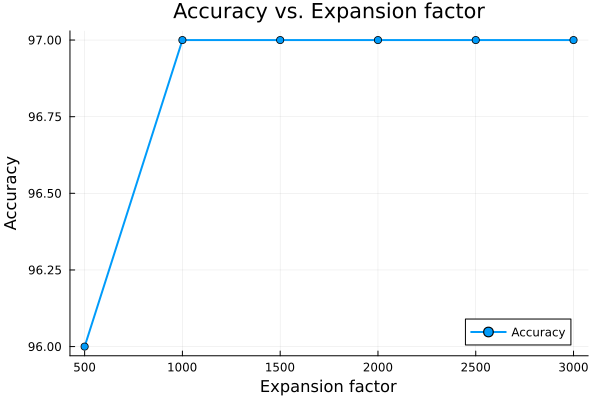

In [47]:
df = CSV.read("./data/mnist.csv", DataFrame)
X = transpose(Matrix(df[:, 1:end-1]))
y = Vector(df[:, end])

accuracies = evaluate_model_accuracy(X, y, exp_factors)

plot(exp_factors, accuracies, 
 label="Accuracy",
 xlabel="Expansion factor", 
 ylabel="Accuracy",
 title="Accuracy vs. Expansion factor",
 legend=:bottomright,
 marker=:circle,
 linewidth=2)

### Dataset `wind`

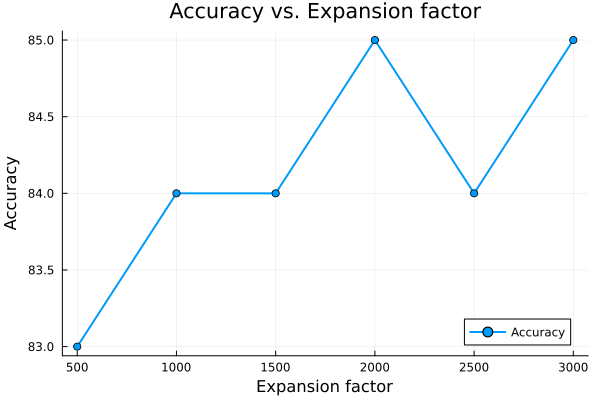

In [48]:
df = CSV.read("./data/wind.csv", DataFrame)
X = transpose(Matrix(df[:, 1:end-1]))
y = Vector(df[:, end])

accuracies = evaluate_model_accuracy(X, y, exp_factors)

plot(exp_factors, accuracies, 
 label="Accuracy",
 xlabel="Expansion factor", 
 ylabel="Accuracy",
 title="Accuracy vs. Expansion factor",
 legend=:bottomright,
 marker=:circle,
 linewidth=2)

## Computing performance evaluations

Finally, we evaluate the performance of the distributed implementation by measuring the execution time of the algorithm as the number of worker processes varies.

* The algorithm is executed on a single machine: a laptop with a 6-core Intel Core i7-9750H processor and 16GB of RAM;
* The algorithm is run on a randomly generated dataset with size $n = 60{,}000$ and dimensionality $d = 20$;
* The projection dimensionality is fixed at $m = 50{,}000$, and $k = d \log m$.

Performance is evaluated in two scenarios:

1. Each worker process uses a single thread. The algorithm is tested with the number of workers set to \[12, 6, 3, 2, 1];
2. Each worker process uses two threads. The algorithm is tested with the number of workers set to \[6, 3, 2, 1].


In [9]:
rmprocs(workers())

Task (done) @0x00007facf12c39e0

In [ ]:
using MLUtils

X = rand(20, 60_000)
y = rand(0:1, 60_000)

# Dividi in train/test (80% - 20%)
train, test = splitobs((X, y), at = 0.8)

# Estrai X e y da train e test
X_train, y_train = train
X_test, y_test = test;

d = size(X,1)
m = 50_000
k = floor(Int64, d*log(ℯ,m)) # k = d*ln(m)

P = rupm(m,d);

### Case 1

In this case, we evaluate the performance of the distributed algorithm (the optimized version) by varying the number of worker processes in \[12, 6, 3, 2, 1], where each process is single-threaded.

We observe a significant improvement in performance when using two processes, with more moderate gains as the number of workers increases. However, when the number of workers reaches 12, performance drops noticeably. This is because the number of workers is twice the number of physical CPU cores, and excessive parallelism leads to a significant performance degradation.

In [11]:
# List of the number of workers to test
workers_counts = [12, 6, 3, 2, 1]
times = zeros(length(workers_counts))

for (i, n_procs) in enumerate(workers_counts)
    # Add n_procs workers
    addprocs(n_procs)

    try
        # Send the code to all current workers
        @everywhere include("benchmark_functions.jl")
        @everywhere BLAS.set_num_threads(1)
        @everywhere MKL.set_num_threads(1)
        
        # Distribute the data to the newly prepared workers
        X_dist = distribute(X_train)
        y_dist = distribute(y_train)

        if n_procs == 1
            # if n_procs = 1, launch the benchmark on main process
            train_eas_classifier_optimized(X, y, P, k)
            t = @belapsed train_eas_classifier_optimized($X, $y, $P, $k)
        else
            # Run the warm-up and the benchmark
            distributed_train_eas_classifier_optimized(X_dist, y_dist, P, k) # Warm-up
            t = @belapsed distributed_train_eas_classifier_optimized($X_dist, $y_dist, $P, $k)
        end
        times[i] = t
        

    finally
        # Remove all workers to ensure a clean subsequent test
        rmprocs(workers())
    end
end

println("Final results (seconds):")
for (i, n_procs) in enumerate(workers_counts)
    println("- $n_procs processes: $(times[i])")
end

Final results (seconds):
- 12 processes: 16.189881799
- 6 processes: 12.370866749
- 3 processes: 12.955929709
- 2 processes: 14.566734876
- 1 processes: 30.64163597


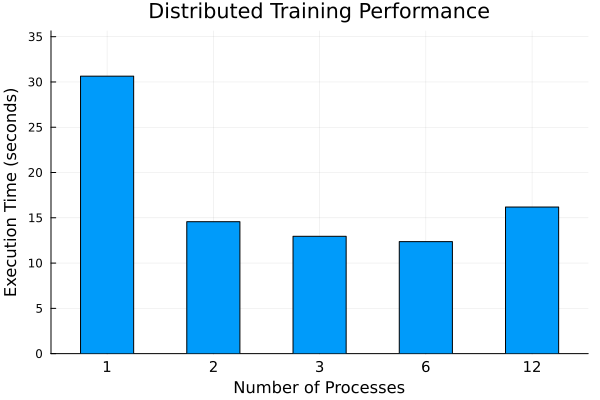

In [12]:
using Plots

bar(
    string.(reverse(workers_counts)),  # X-axis labels as strings
    reverse(times),
    xlabel = "Number of Processes",
    ylabel = "Execution Time (seconds)",
    title = "Distributed Training Performance",
    legend = false,
    bar_width = 0.5,
    xtickfont = font(10),
    yticks = 0:5:maximum(times) + 5,
    ylims = (0, maximum(times) + 5)
)

### Case 2
In this case, we evaluate the performance of the distributed algorithm (the optimized version) by varying the number of worker processes in [6, 3, 2, 1], where each worker uses two threads.

We observe a significant improvement in performance when using two processes, with more moderate gains as the number of workers increases.


In [13]:
# List of the number of workers to test
workers_counts = [6, 3, 2, 1]
times = zeros(length(workers_counts))

for (i, n_procs) in enumerate(workers_counts)
    # Add n_procs workers
    addprocs(n_procs)

    try
        # Send the code to all current workers
        @everywhere include("benchmark_functions.jl")
        @everywhere BLAS.set_num_threads(2)
        @everywhere MKL.set_num_threads(2)
        
        # Distribute the data to the newly prepared workers
        X_dist = distribute(X_train)
        y_dist = distribute(y_train)

        if n_procs == 1
            # if n_procs = 1, launch the benchmark on main process
            BLAS.set_num_threads(2)
            MKL.set_num_threads(2)
            train_eas_classifier_optimized(X, y, P, k)
            t = @belapsed train_eas_classifier_optimized($X, $y, $P, $k)
        else
            # Run the warm-up and the benchmark
            distributed_train_eas_classifier_optimized(X_dist, y_dist, P, k) # Warm-up
            t = @belapsed distributed_train_eas_classifier_optimized($X_dist, $y_dist, $P, $k)
        end
        times[i] = t
        

    finally
        # Remove all workers to ensure a clean subsequent test
        rmprocs(workers())
    end
end

println("Final results (seconds):")
for (i, n_procs) in enumerate(workers_counts)
    println("- $n_procs processes: $(times[i])")
end

Final results (seconds):
- 6 processes: 12.360080502
- 3 processes: 10.469053249
- 2 processes: 13.440366074
- 1 processes: 26.02149734


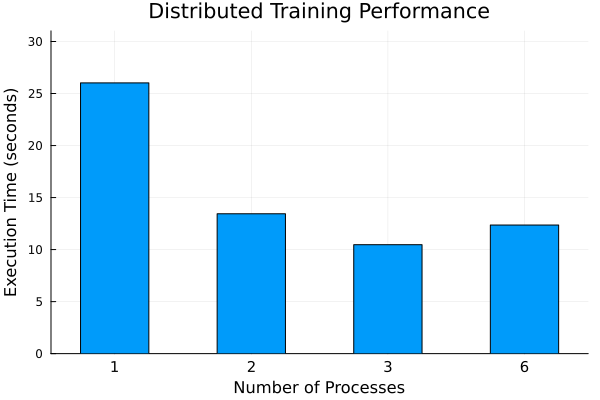

In [14]:
bar(
    string.(reverse(workers_counts)),  # X-axis labels as strings
    reverse(times),
    xlabel = "Number of Processes",
    ylabel = "Execution Time (seconds)",
    title = "Distributed Training Performance",
    legend = false,
    bar_width = 0.5,
    xtickfont = font(10),
    yticks = 0:5:maximum(times) + 5,
    ylims = (0, maximum(times) + 5)
)

## Conclusions
This notebook demonstrates a distributed implementation of a non-parametric classification method using an expand-and-sparsify (EaS) representation. The EaS representation transforms low-dimensional sensory inputs into a higher-dimensional, sparse representation, mimicking a process found in the fly's olfactory system. The classification is achieved by using the "activated" response regions of the EaS representation as neighborhoods to estimate class probabilities. The implementation was conducted using the Julia programming language, with the aim of exploring a distributed approach to this non-parametric classifier.